# Load Forecasting

## Herman Carstens EES732 2015

This is a tutorial on the basics of one method of load forecasting (linear regression) prepared for EES732 (Energy Management), and written in Jupyter (IPython Notebook). In order to play around with the code, download this notebook from the GitHub repository. The link should be top right.

This notebook discusses some basic theory needed for load forecasting, as well as three examples.

## Some preliminaries

This is just to set up Python and import the relevant libraries

In [21]:
%matplotlib inline 
#Displays graphs automatically
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style="darkgrid")
from pandas import set_option
set_option("display.max_rows",16,"display.max_columns",13)
import matplotlib.pyplot as plt         
pd.options.display.mpl_style='default'
from pylab import rcParams
rcParams['figure.figsize']=18,8 #figure sizes
import statsmodels.api as sm

Much of this tutorial is based on [*Assessment of Automated Measurement and Verification (M&V) Methods* (2015) by Granderson et al., Lawrence Berkeley National Laboratory (LBNL-187225)](http://eetd.lbl.gov/publications/assessment-of-automated-measurement-a). Please cite the paper rather than this tutorial.

## Introductory Theory

## What is a load forecasting model?

A mathematical method or set of equations that can predict future energy use.

Methods can be based on various considerations: Time of day, energy use at the previous time interval, occupancy, temperature (called covariates), the energy use of a similar day, etc.

The mathematical model will give you a load profile (forecast), or energy uses at different times of the day, or the total energy use for a day or a week or a month.

Note that 'forecast' refers to future data that we don't have. 'Predict' refers to the model's fit of the data we do have.

## Load forecasting metrics

What is a "good" model?

A "good" model is one that forecasts accurately according to certain metrics:
* Total Error
* Mean Error
* Root Mean Square Error
* Total Bias
* Coefficient of Determination ($R^{2}$)
* **Coefficient of Variance on the Root Mean Square Error: CV(RMSE)**
* **Normalised Mean Bias Error**

The last two methods are widely accepted the most useful ones, and complement each other well.

## CV(RMSE) and NMBE

**CV(RMSE):** A measure of well the model fits the data.

**NMBE:** An expression for the actual forecast error, in percentage terms.

## Coefficient of Variance on the Root Mean Square Error - CV(RMSE)

Let:
* $N$ be the number of data points in the evaluation (post-retrofit) period
* $y_{i}$ be the energy measured at the $i^{th}$ time interval
* $\hat{y_{i}}$ (pronounced "y hat") be the energy predicted at the $i^{th}$ time interval
* $\bar{y}$ ("pronounced "y bar") be the mean energy use over the evaluation period

$CV(RMSE)=\frac{\sqrt{\frac{1}{N}\sum_{i}^{N}(y_{i}-\hat{y}_{i})^{2}}}{\bar{y}}\times 100$

Logic:
* Find the differences between forecast and actual energy use at each data point: the Errors **(E)** (or bias)
* Square these differences: the Squared Errors **(SE)**
* Sum them, and divide them by the number of data points / measurements to find the mean: the Mean Square Error **(MSE)**
* Find the square root: the Root Mean Square Error **(RMSE)**
* Normalise by dividing by the average energy use during the period: the RMSE with respect to the actual mean **CV(RMSE)**

## The Normalised Mean Bias Error

$NMBE = \frac{\frac{1}{N}\sum_{i}^{N}(y_{i}-\hat{y}_{i})}{\bar{y}}\times 100$

Logic:
* Find the differences between the forecast and actual values: the Bias Error **(BE)**
* Sum them, divide the the number of points: Mean Error **(MBE)**
* Normalise by dividing by the mean energy use: Normalised Mean Bias Error **(NMBE)**

**Digression**: Why not call this the CV(MBE), or call the CV(RMSE) the NMRSE? Why do we call it normalisation in the one case and CV in the other?

Traditionally, $CV=\frac{\sigma}{\mu}=\frac{STDEV}{MEAN}$. It's like the normalised standard deviation.
The standard deviation is calculated as a *squared error*. So in some ways, CV(RMSE) is a bit like the standard deviation of your *model* w.r.t. the *observed data*, divided by the mean

## Load Forecasting methods

So now that we know what a good model would look how, how do we build them?

Dozens of methods are available:
* ARIMA (Autoregressive Integrated Moving Average). A Time Series Forecasting Method
* Calibrated Simulation
* ANN (Artificial Neural Networks)
* Fourier Series Models
* PCA (Principal Component Analysis) Regression
* SVM (Support Vector Machines)
* Linear Regression
* Nearest Neighbour

We will focus on *Linear Regression*: Good value for money. Simple and relatively accurate, though not the best. For the shootout and results, see [Granderson et al](http://eetd.lbl.gov/publications/assessment-of-automated-measurement-a).


## What is regression?

Easy! 

**$Y=X \beta + \epsilon$**

But this is matrix notation, so actually:

$Y=\beta_{1}\beta_{1}+\beta_{2}x_{2}+\beta_{3}x_{3}+\beta_{4}x_{4}+...+ \beta_{n} + \epsilon$

where, for example,
* $\beta_{1}$ is the temperature coefficient, and $x_{1}$ is the temperature
* $\beta_{2}$ is the occupation coefficient, and $x_{2}$ is the occupation
* $\beta_{3}$ is the time of day coefficient, and $x_{3}$ is the time of day
* $\beta_{n}$ is the intercept (note: no $x$ term)
* $\epsilon$ is the error (should be Gaussian if you identified all of the significant covariates)

*Note: Regression is a huge field, this is just a small introduction. We will be doing OLS - Ordinary Least Squares - regression.*

## How do I do regression?

It depends on the program you use. But the steps are:
1. Identify the data and all the covariates (temp, occupation, time of day, etc.)
2. Find the regression coefficients for the vector **$\beta$** (the tricky, program-specific bit)
3. Validate your result
4. Measure the covariates for the reporting/evaluation period
5. Multiply the reporting period data by the coefficients to find the scalar value Y (called the reponse)

## Example 1: Energy use and Temperature

This example is taken from *Energy Efficiency Measurement and Verification Practices* (2012), Chapter 3, by X. Xia & J. Zhang.

The energy use and average monthly maximum temperature at a facility have been given to us in a csv file:

In [22]:
monthly_baseline=pd.read_csv('monthly_baseline.csv',sep='\;',index_col=0,parse_dates=True,engine='python')
monthly_baseline

,Baseline_Temp,Baseline_Energy
Month,,
2014-01-31,20.5,12625
2014-01-28,22.0,12927
2014-03-31,19.0,12706
2014-04-30,15.0,12324
2014-05-31,13.0,11519
2014-06-30,10.5,11116
2014-07-31,14.7,11160
2014-08-31,20.3,12137
2014-09-30,21.3,12585


Let's visualise the data. It's not necessary for the calculation, but it's always a good idea. We will plot energy use in blue, and temperature in red in a dual-y-axis graph:

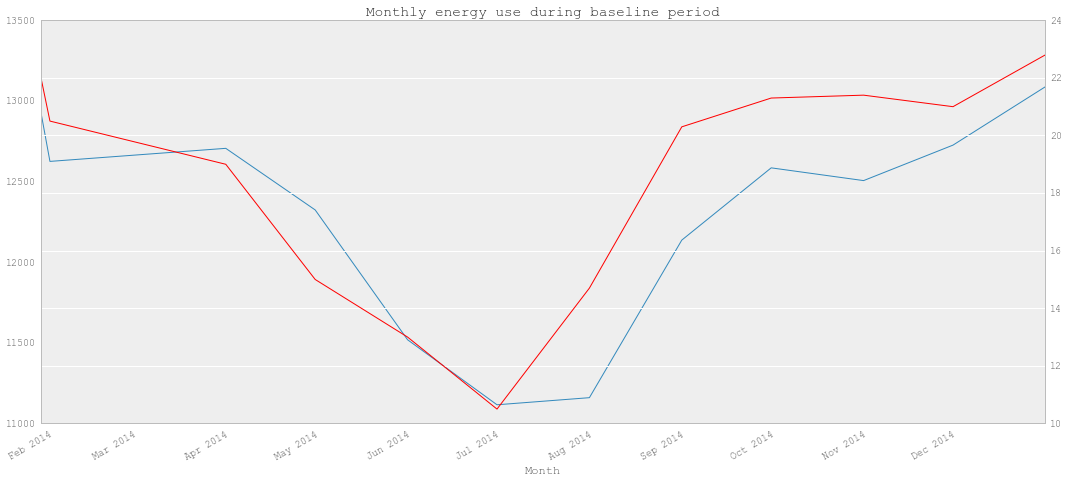

In [23]:
monthly_baseline.Baseline_Energy.plot(title='Monthly energy use during baseline period')
monthly_baseline.Baseline_Temp.plot(secondary_y=True, style='r')

We can see that the energy use decreases as temperature decreases. However, it doesn't give us the relationship between energy use an temperature. For this, we need to do a regression. Assuming a simple linear form, (linear regression doesn't necessary imply straight lines, but in this case we will assume a straight-line relationship):

$E = \alpha T + \epsilon$

where

$E$ is the monthly energy use

$\alpha$ is the temperature regression coefficient

$T$ is the average monthly maximum temperature

$\epsilon$ is the error

We can plot this quite easily using the `seaborn` module, with 90% confidence intervals on the regression:

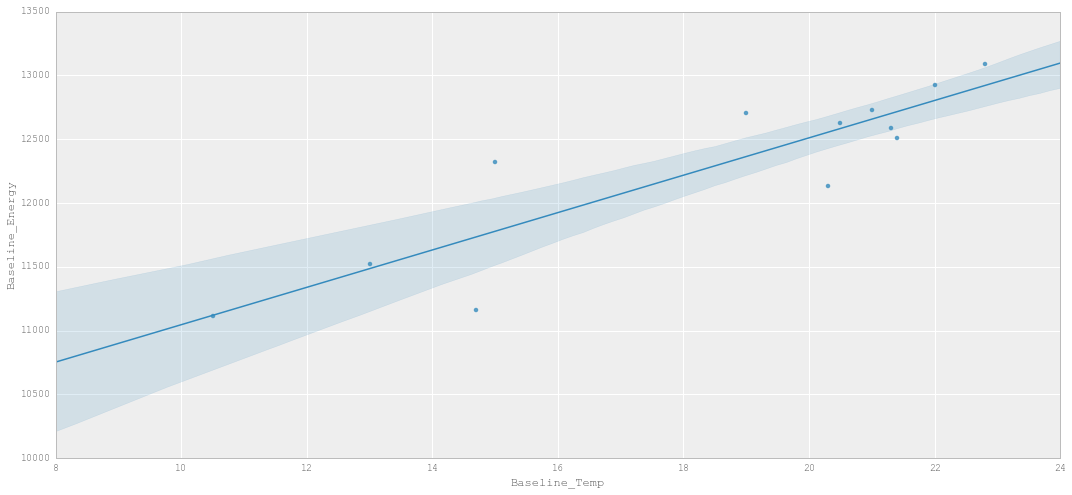

In [24]:
sns.regplot(x='Baseline_Temp',y='Baseline_Energy', data=monthly_baseline, ci=90)

The fit indicated is the least-squares best fit line, which is the one that minimises the squared errors:

**min** $\sum_{1}^{N}(y_{i}-\hat{y}_{i})^{2}$

This is what OLS-regression means.

In order to find the intercept and slope numerically, we can consult the `statsmodels` package, which is the one called in the background by `seaborn` to do the plot above.

`Patsy` is another library that we will use to create the matrix/dataframe that we need for the regression. It converts our equation into the matrix, taking categorical variables and such things into account, and translating it into an acceptable `statsmodels` input.

In [25]:
from patsy import dmatrices
energy1, Temp1 = dmatrices('Baseline_Energy ~ Baseline_Temp', data=monthly_baseline, return_type='dataframe')
mod = sm.OLS(energy1,Temp1)
res = mod.fit()
print res.summary()

                            OLS Regression Results                            
Dep. Variable:        Baseline_Energy   R-squared:                       0.791
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     37.95
Date:                Wed, 28 Oct 2015   Prob (F-statistic):           0.000107
Time:                        10:01:03   Log-Likelihood:                -85.171
No. Observations:                  12   AIC:                             174.3
Df Residuals:                      10   BIC:                             175.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept      9580.8465    448.566     21.359

From this we can see that there is a two-thirds chance that the slope parameter lies in the interval [123 ; 170] and the intercept lies in the interval [9 132 ; 10 029]. The model can thus be written as:

$E_{Adj. Baseline}=146.59\times T_{Reporting Period}+ 9580.85$

Although the goodness of fit metrics above are useful, we need to validate the baseline model by seeing how well it predicts the baseline energy use.

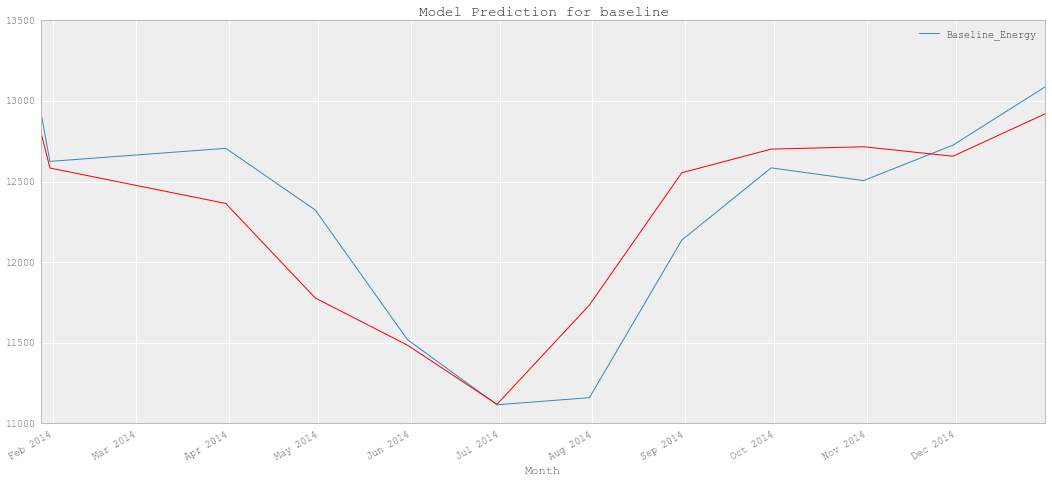

In [26]:
monthly_baseline['model_prediction']=monthly_baseline.Baseline_Temp*146.49+9580.85
monthly_baseline.Baseline_Energy.plot(title='Monthly energy use during baseline period',legend=True)
monthly_baseline.model_prediction.plot(title='Model Prediction for baseline',color='r')

They seem to be quite close. We note that it underpredicts energy consumption during the first half of the year, and overpredicts it during most of the second half. But we can measure the goodness of fit objectively using the CV(RMSE) and NMBE as described above.  We'll code them as functions to use later. Remember that:

$CV(RMSE)=\frac{\sqrt{\frac{1}{N}\sum_{i}^{N}(y_{i}-\hat{y}_{i})^{2}}}{\bar{y}}\times 100$


In [27]:
def CVRMSE (y,y_hat):
    return np.sqrt(np.sum((y-y_hat)**2)/len(y))/np.mean(y)*100
        
CVRMSE_monthly_baseline=CVRMSE(monthly_baseline.Baseline_Energy,monthly_baseline.model_prediction)
CVRMSE_monthly_baseline

2.3814860873110968

$NMBE = \frac{\frac{1}{N}\sum_{i}^{N}(y_{i}-\hat{y}_{i})}{\bar{y}}\times 100$

In [28]:
def NMBE(y,y_hat):
    return np.sum(y-y_hat)/len(y)/np.mean(y)*100

NMBE_monthly_baseline=NMBE(monthly_baseline.Baseline_Energy,monthly_baseline.model_prediction)
NMBE_monthly_baseline

0.0008580983455280262

According to the definitive ASHRAE 14-2002 Guideline, CV(RMSE) for energy models during the training period should be less than 25%. There is no clear guideline for NMBE, but the models tested by [Lawrence Berkeley shootout cited above](http://eetd.lbl.gov/publications/assessment-of-automated-measurement-a), NMBE's ranged from 0.5 to -4.
It should be noted that these values were for models on a 15-minute time scale, not a monthly time scale. Nevertheless, we can be satisfied with the accuracy of our model, given the data at hand.

Let us now move to the reporting (post-implementation) period. First we import the data:

In [31]:
monthly_reporting=pd.read_csv('monthly_reporting.csv',sep='\;',index_col=0,parse_dates=True,engine='python')
monthly_reporting

,Reporting_Temp,Reporting_Energy
2015-01-31,22.5,9888
2015-01-28,23.3,12410
2015-03-31,22.6,14100
2015-04-30,18.1,11938
2015-05-31,15.8,9528
2015-06-30,11.4,9168
2015-07-31,13.2,12028
2015-08-31,15.4,12648
2015-09-30,20.4,10368
2015-10-31,22.9,8088


Using our model, we can now predict what the energy use *would have been*, had no changes been made. We call this the 'adjusted baseline':

In [32]:
monthly_reporting['adj_baseline']=monthly_reporting.Reporting_Temp*146.49+9580.85
monthly_reporting

,Reporting_Temp,Reporting_Energy,adj_baseline
2015-01-31,22.5,9888,12876.875
2015-01-28,23.3,12410,12994.067
2015-03-31,22.6,14100,12891.524
2015-04-30,18.1,11938,12232.319
2015-05-31,15.8,9528,11895.392
2015-06-30,11.4,9168,11250.836
2015-07-31,13.2,12028,11514.518
2015-08-31,15.4,12648,11836.796
2015-09-30,20.4,10368,12569.246
2015-10-31,22.9,8088,12935.471


Plotting the adjusted baseline and actual reporting period energy use, we find the following figure:

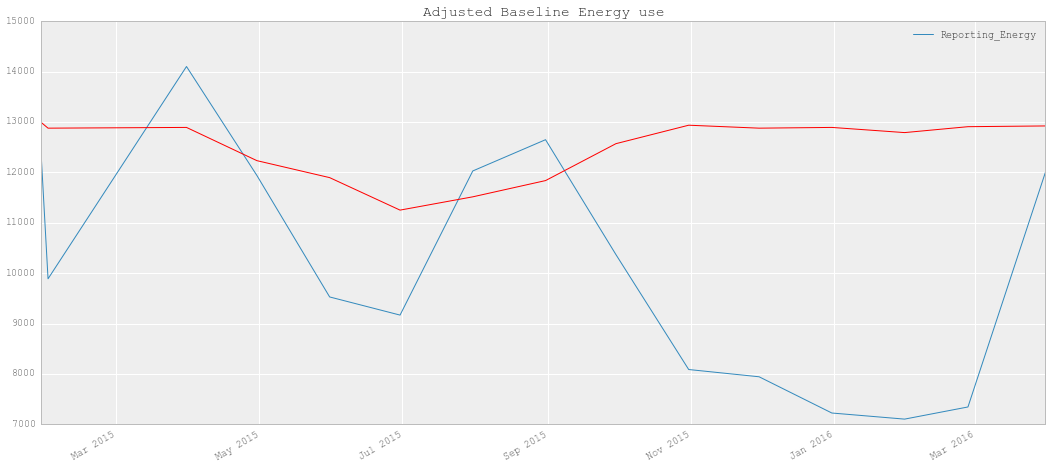

In [33]:
monthly_reporting.Reporting_Energy.plot(legend=True,
                                        title='Comparison of reporting period energy use to forecast energy use')
monthly_reporting.adj_baseline.plot(title='Adjusted Baseline Energy use', color='r')

We can see that the reporting period energy use is lower than the adjusted baseline energy use, although the patterns don't match perfectly (this is a real-world example, after all). For what it's worth, we can calculate the energy savings as:

In [34]:
total_savings = monthly_reporting.adj_baseline.sum(axis=0)-monthly_reporting.Reporting_Energy.sum(axis=0)
#print(str(total_savings) + ' kWh')
print("{:.2f}".format(total_savings)+ " kWh")

35599.42 kWh


The percentage savings can be calculated as:

In [35]:
percentage_savings=total_savings/monthly_reporting.Reporting_Energy.sum(axis=0)*100
print("{:.2f}".format(percentage_savings) + '%')

23.45%


## Example 2: Buying a Car

When you buy a car, there are many factors that may influence the price. How do you know that you are getting a good deal? Mileage and year model are two of the significant quantifiable ones you could use to judge this, but there are also certain *categorical* variables, such as the colour and transmission type. The model year can also be seen as a categorical variable rather than a continuous one. We'll consider Suzuki Jimnies as our case study:
<img src="2015-Suzuki-Jimny.jpg", style="width: 500px">

I've entered the data from 38 Jimnies for sale on [Gumtree](www.gumtree.co.za) during September 2015 into an Excel file, and saved it as Jimnies.csv

Notice how we now have continuous variables (mileage) as well as categorical variables (colour, sale location) and ordinal variables (year). This makes our regression more interesting, and we'll need to handle these kinds of variables when we do the load forecasting example.

Let's import the data set:

In [36]:
jimnies=pd.read_csv('Jimnies.csv',sep='\;',index_col=0,engine='python')
jimnies

,Mileage,Colour,Transmission,Province,Price
Year,,,,,
2015,1200,Green,A,WC,249900
2015,4400,Silver,A,GP,236400
2015,1000,White,A,WC,229900
2015,7056,White,M,KZN,224990
2015,1,Other,M,WC,224900
2015,400,White,A,WC,219900
2015,6500,Charcoal,A,KZN,215000
2015,2,White,M,WC,214900
...,...,...,...,...,...


Note that 'mileage' here refers to kilometers.

Let's plot mileage vs. price, just to see what we are dealing with:

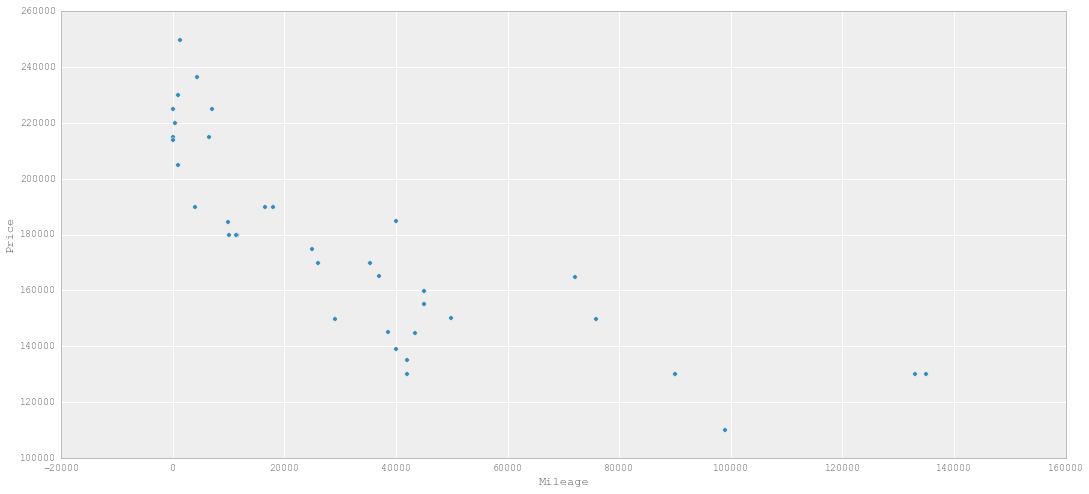

In [37]:
jimnies.plot(kind="scatter", x='Mileage', y='Price')
#jimnies.plot?

From this plot we can see that the relationship between mileage and price is definitely not linear in the sense of $y=mx+c$ relationship. However, this does not mean that we can't use linear regression, since the 'linear' in linear regression refers to the linear algebra used to solve the $Y=\beta X$ equation.

The covariates are not continuous variables, and so non-linearity isn't an issue in the same way.

Let's see if we can transform the x-axis to give us a straight line. 



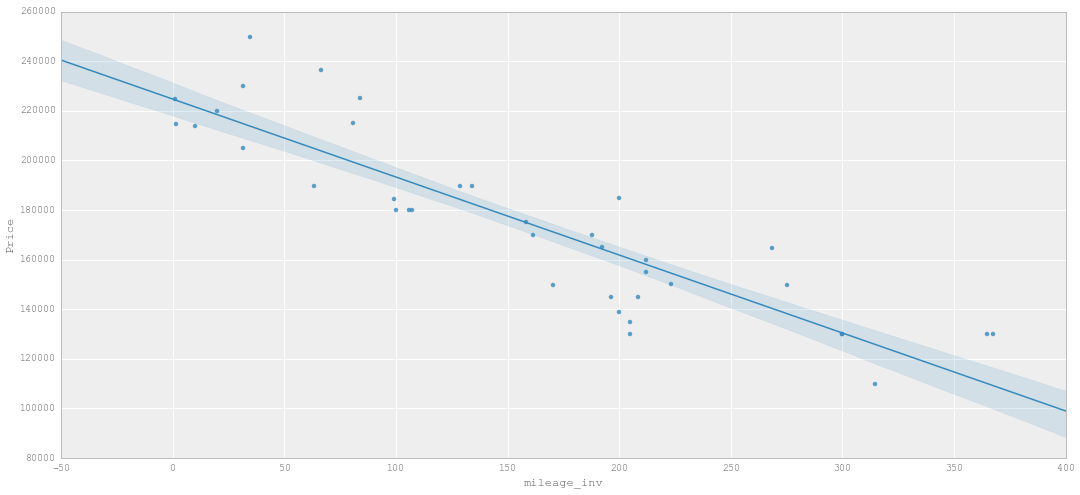

In [38]:
jimnies['mileage_inv']=jimnies.Mileage**0.5
#jimnies.plot(kind="scatter", x='mileage_inv', y='Price')
sns.regplot(x='mileage_inv',y='Price', data=jimnies, ci=80)


Furthermore, you can see that there is a spread on the data. For say, about 40 000 km, the price varies between about R130 000 and R190 000. If we were only regressing price against mileage, this is what we would know. However, we have more information about each of those points, in terms of the colour, model year, and transmission of the unit under consideration. This might be what is forcing certain data points up or down. These would all be dimensions orthogonal on the xy-plane plotted above, and so they are difficult to visualise simultaneously.

Now we can fit a regression model to the data by specifying the model in `patsy` and fitting it with `statsmodels`. The model we are specifying may be written in mathematical notation as

$Price=$

We will fit a regression model to the data using `Python`'s [`statsmodels`](http://statsmodels.sourceforge.net/devel/examples/notebooks/generated/ols.html) library. Most programming languages have similar functions.

In [39]:
price,X = dmatrices('Price ~ mileage_inv + C(Colour) + C(Transmission) + C(Province) + C(jimnies.index)',
                    data=jimnies, return_type='dataframe')
mod = sm.OLS(price,X)
res = mod.fit()
print res.summary()

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.942
Method:                 Least Squares   F-statistic:                     29.72
Date:                Wed, 28 Oct 2015   Prob (F-statistic):           4.04e-09
Time:                        10:02:07   Log-Likelihood:                -381.92
No. Observations:                  38   AIC:                             807.8
Df Residuals:                      16   BIC:                             843.9
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------
Intercept               

Let's ignore the warning for the moment.

From the summary statistics above, we can see that we are not at all sure about some of the values for Province and Colour. This should not come as a surprise: there are not many cars available in Green or Red, or in KZN, Mpumalanga, or the Free State. Their $P>|t|$ values (which is a measure of how likely such values would be, given only chance) is close to 100%. In other words they may as well be random, tell us nothing, and may contribute to [overfitting](https://en.wikipedia.org/wiki/Overfitting).

**Note**: Removing them may decrease the $R^{2}$ value, making it seem as if our model is worse off when it isn't (Read more about it [here](https://en.wikipedia.org/wiki/Coefficient_of_determination)). This is one of the reasons $R^{2}$ isn't one of our metrics of choice. So let us remove the Province and Colour Factors.

The real-world significance of those coefficients are that, for the model year, for instance, a 2015 Jimny will cost R9220 more than the "average", $\pm$ R2050, 67% (one standard deviation) of the time.

Ok, so let's remove the car colour and sale province from the data set:

### Model with Mileage, Transmission, and Model Year

In [40]:
price,X_MTY = dmatrices('Price ~ mileage_inv + C(Transmission) + C(jimnies.index)',
                    data=jimnies, return_type='dataframe')
mod_MTY = sm.OLS(price,X_MTY)
res_MTY = mod_MTY.fit()
print res_MTY.summary()

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     60.38
Date:                Wed, 28 Oct 2015   Prob (F-statistic):           5.77e-16
Time:                        10:02:07   Log-Likelihood:                -394.71
No. Observations:                  38   AIC:                             809.4
Df Residuals:                      28   BIC:                             825.8
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------
Intercept               

Our $P>|t|$ values look a bit better, but we seem to still have this warning about a condition number and '[multicollinearity](https://en.wikipedia.org/wiki/Multicollinearity)'. What does this mean? (Multi)Colinearity means that our factors are somehow related to one another. Let's do a scatterplot to see what's going on. We'll plot it against `mileage_inv` as that is what the OLS algorithm sees:

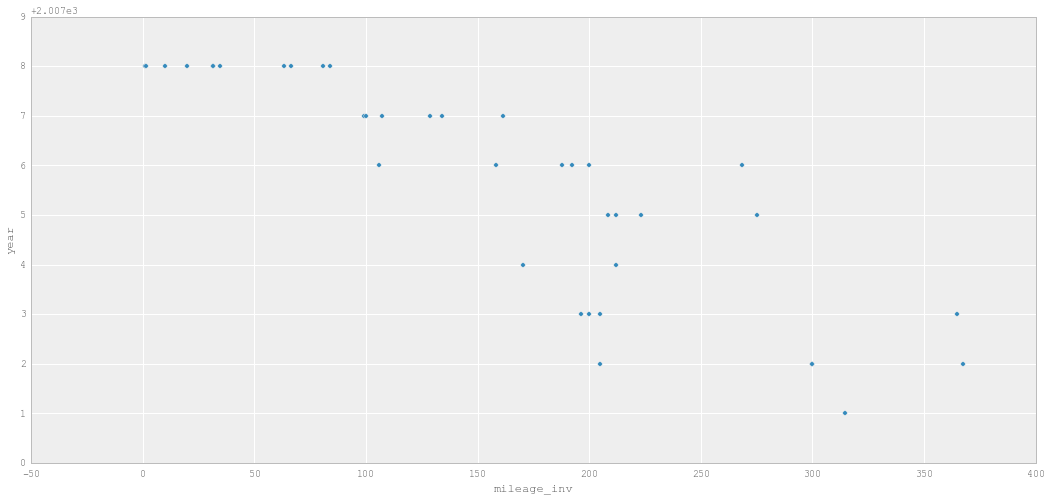

In [41]:
jimnies['year']=jimnies.index
jimnies.plot(kind='scatter',x='mileage_inv',y='year')

So there seems to be quite a strong correlation: higher mileage cars are generally older (go figure!).  40 000 - 50 000 km ($200^{2}$) does seem to be a popular mileage to sell a Jimny on, though. But multicollinearity is a problem for our model, because either model year or mileage may be contributing to the high price, and we don't really know which it is.

So we have two options: leave both in, including as much information as we can at the risk of overfitting, or take out either the year or the mileage factor. Let's see what happens when we take either one out:

### Considering only Transmission and Mileage

In [42]:
price,X_MT = dmatrices('Price ~ mileage_inv + C(Transmission)',
                    data=jimnies, return_type='dataframe')
mod_MT = sm.OLS(price,X_MT)
res_MT= mod_MT.fit()
print res_MT.summary()

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     98.40
Date:                Wed, 28 Oct 2015   Prob (F-statistic):           4.28e-15
Time:                        10:02:08   Log-Likelihood:                -416.09
No. Observations:                  38   AIC:                             838.2
Df Residuals:                      35   BIC:                             843.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
Intercept             2.429e+05 

### Considering only Transmission and Model Year

In [43]:
price,X_TY = dmatrices('Price~ C(Transmission) + C(jimnies.index)',
                    data=jimnies, return_type='dataframe')
mod_TY = sm.OLS(price,X_TY)
res_TY = mod_TY.fit()
print res_TY.summary()

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.947
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     64.27
Date:                Wed, 28 Oct 2015   Prob (F-statistic):           2.26e-16
Time:                        10:02:09   Log-Likelihood:                -396.34
No. Observations:                  38   AIC:                             810.7
Df Residuals:                      29   BIC:                             825.4
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------
Intercept               

Here we can see that considering mileage seems to be less accurate than considering model year.

### Comparing the models

Instead of using $R^{2}$ only, let's investigate CVRMSE and NMBE as well:

In [44]:
print("\tCVRMSE \t\t R^2 \t\tNMBE")
print("MTY:\t" + "{:.3f}".format(CVRMSE(jimnies.Price,res_MTY.predict(X_MTY)))+"\t\t {:.3f}".format(res_MTY.rsquared)+"\t\t {:.3f}".format(NMBE(jimnies.Price,res_MTY.predict(X_MTY))))
print("MT:\t" + "{:.3f}".format(CVRMSE(jimnies.Price,res_MT.predict(X_MT)))+"\t\t {:.3f}".format(res_MT.rsquared)+ "\t\t {:.3f}".format(NMBE(jimnies.Price,res_MT.predict(X_MT))))
print("TY:\t" + "{:.3f}".format(CVRMSE(jimnies.Price,res_TY.predict(X_TY)))+"\t\t {:.3f}".format(res_TY.rsquared)+ "\t\t {:.3f}".format(NMBE(jimnies.Price,res_TY.predict(X_TY))))

	CVRMSE 		 R^2 		NMBE
MTY:	4.487		 0.951		 0.000
MT:	7.877		 0.849		 0.000
TY:	4.684		 0.947		 -0.000


It seems that the model considering Mileage, Transmission, and Year (MTY) is the most accurate, but as we said before, it could be due to overfitting. They way to test this would be to see what happens when we leave certain data points out. This could then give us some idea of what the model would predict for the actual data set (this being the training data set). However, such an investigation would take us too far afield, and so we'll leave it at that for the moment.

Note that `statsmodels` makes it really easy to do the predictions. If you have to this manually, it gets quite tedious, because for each data point you have to decide into which of the 8 categories the model year falls, and add/muiltiply the appropriate coefficient. You could also do this with matrix algebra, of course. Most computer languages at your disposal should do this automatically.

## Example 3: Load Forecasting

Finally we get to the real example. But before we do, note that this method is taken from [*Quantifying Changes in Building Electricity Use, With Application to Demand Response* by J. L. Mathieu, P. N. Price, S. Kiliccote, M.A. Piette, IEEE Transactions on Smart Grid, Vol. 2, No. 3, September 2011](http://ieeexplore.ieee.org/xpl/login.jsp?tp=&arnumber=5772947&url=http%3A%2F%2Fieeexplore.ieee.org%2Fxpls%2Fabs_all.jsp%3Farnumber%3D5772947). The reason for this is explained in [Granderson et al.](http://eetd.lbl.gov/publications/assessment-of-automated-measurement-a), at the beginning of this notebook.

In this example, we have the building energy use and temperature data for a given building for 2015. We want to create a load forecasting model so that we can forecast the 2015 energy use, given that we already have 2015's temperature data as well. We actually have the 2015 energy use data as well, but we'll use that at the end to check our forecast accuracy.

In [45]:
from patsy import dmatrices
building2014=pd.read_csv('building2014.csv',sep='\;',index_col=0,parse_dates=True,engine='python')
building2014.index.names=['Date_Time']
building2014

,Temp,WindChill,HeatIndex,THWIndex,THSWIndex,kW
Date_Time,,,,,,
2014-01-01 00:30:00,20.1,20.1,20.1,20.1,17.8,146
2014-01-01 01:00:00,19.8,19.8,19.9,19.9,17.7,148
2014-01-01 01:30:00,19.3,19.3,19.6,19.6,17.3,145
2014-01-01 02:00:00,19.1,19.1,19.3,19.3,17.1,144
2014-01-01 02:30:00,18.7,18.7,18.9,18.9,16.7,152
2014-01-01 03:00:00,18.3,18.3,18.6,18.6,16.3,145
2014-01-01 03:30:00,18.0,18.0,18.2,18.2,15.9,146
2014-01-01 04:00:00,17.4,17.4,17.6,17.6,15.3,141
...,...,...,...,...,...,...


Here we can see that there are different ways to measure thermal comfort: Average (Temp), considering wind chill, the heat index, the THW index, or the THSW index. We'll keep them for now, so that we can decide on the most accurate one later.

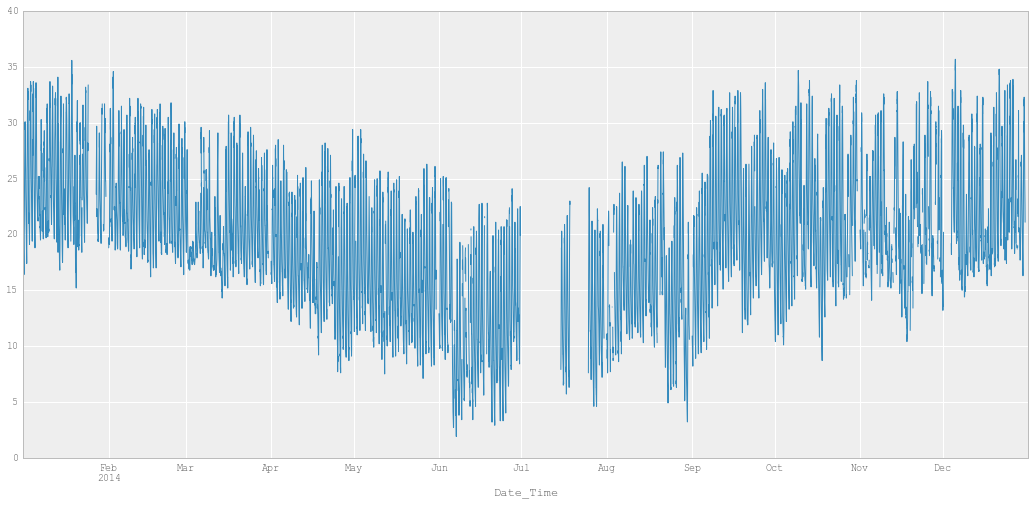

In [46]:
building2014.Temp.plot()

We can see that there is some missing data in July-August. It shouldn't be too much of a problem, although we will lose some information about the energy-temperature correlation during cold days.

## Time-of-Week Indicator

We now need to find the 'time of week' for each time period. Since we have 47 time periods per day, and 7 days in a week, we will have 329 time-of-week periods. This is a categorical variable. How you define your time of week period is up to you; in `Pandas` it is easy to get the day-of-week number (the `weekday` property of the dataframe index, which is of the `Datetime` class). We can combine this with the time of day. The format is DayNumber_Time, with Monday being DayNumber=0.


In [47]:
#Unfortunately, this is inelegant:
a=pd.Series(building2014.index.time).tolist()
b=pd.Series(building2014.index.weekday).tolist()
weektime_df=pd.DataFrame(data=pd.Series(["{}_{}".format(b,a) for a,b in zip(a, b)]),columns=["weektime"])
weektime_df.index=building2014.index
building2014['weektime']=weektime_df.weektime
building2014

,Temp,WindChill,HeatIndex,THWIndex,THSWIndex,kW,weektime
Date_Time,,,,,,,
2014-01-01 00:30:00,20.1,20.1,20.1,20.1,17.8,146,2_00:30:00
2014-01-01 01:00:00,19.8,19.8,19.9,19.9,17.7,148,2_01:00:00
2014-01-01 01:30:00,19.3,19.3,19.6,19.6,17.3,145,2_01:30:00
2014-01-01 02:00:00,19.1,19.1,19.3,19.3,17.1,144,2_02:00:00
2014-01-01 02:30:00,18.7,18.7,18.9,18.9,16.7,152,2_02:30:00
2014-01-01 03:00:00,18.3,18.3,18.6,18.6,16.3,145,2_03:00:00
2014-01-01 03:30:00,18.0,18.0,18.2,18.2,15.9,146,2_03:30:00
2014-01-01 04:00:00,17.4,17.4,17.6,17.6,15.3,141,2_04:00:00
...,...,...,...,...,...,...,...


## Preliminary Regression

We haven't implemented the full model from the article yet, but we can do a regression using only the time-of-week indicator, to see how that fares.

In [48]:
regression_equation='kW ~ weektime*Temp'
Energy,X_building = dmatrices(regression_equation, data=building2014, return_type='dataframe')
mod_building = sm.OLS(Energy,X_building)
res_building= mod_building.fit()
#print res_building.summary()
y_prediction,X_building2014_predict = dmatrices(regression_equation, data=building2014, return_type='dataframe')
energy_prediction=res_building.predict(X_building2014_predict)

We can now predict the energy use given the temperatures experienced during 2014, to see how well our model fits the known data. 

Note that what isn't shown here is that lower down in this (long) series, we have missing data.

Now we add the forecast as a second column. The thing with `statsmodels 0.6` (the latest version) is that it doesn't handle missing data so well (improvements are promised for 0.7 or 0.8). And we do have missing data. You'll notice that our `energy_forecast` variable is shorter than the actual length of time:

In [49]:
np.size(energy_prediction)

15391

In [50]:
np.size(building2014.Temp)

17519

Note that this *may* not be problem in other programming languages, but for `Python`, we now have to put the forecast values in the right places, and leave the right ones blank (or `NaN`: Not a Number). Otherwise our forecast will start lagging from the first time point where we're missing energy data:

In [51]:
building2014['prediction']='' #create a blank column
k=0 #this is the counter for the forecast variable. It doesn't increment if there is no temperature data 
    #for that time point.

In [53]:
for i in range (0,np.size(building2014.Temp)):
    if pd.notnull(building2014.Temp[i]) and k<np.size(energy_prediction): #if there is a Temperature reading for that time period, then...
        #Note that there is a bit of a hack in the line above, since it bombs out if I dont add the k<... condition.
        building2014.ix[i,'prediction']=energy_prediction[k] #allocate the right forecast point to that time period
        k+=1 #increment forecast counter
    else:
        building2014.ix[i,'prediction']=np.NaN #Skip that time period, write NaN.

Let's plot a random section of the two, to compare them to one another:

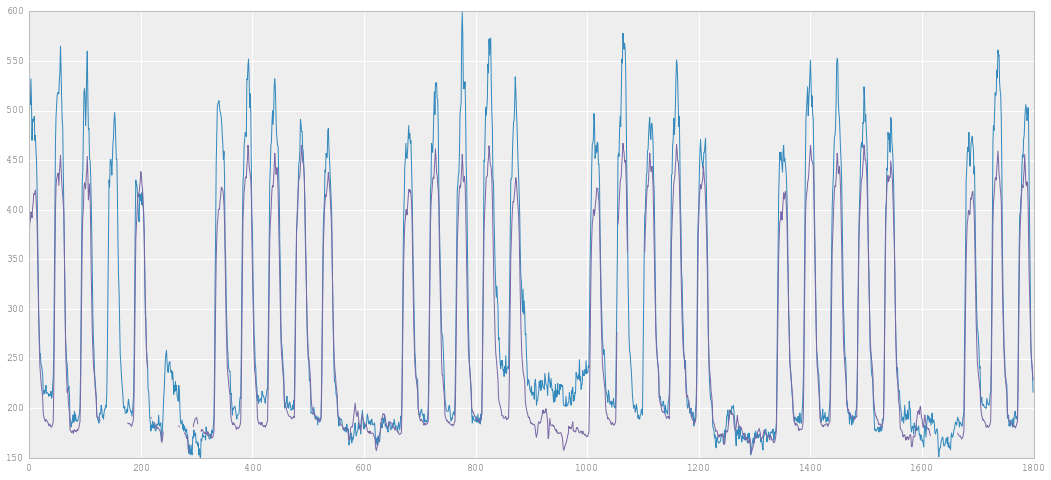

In [54]:
plt.plot(building2014.kW[10000:11800])
plt.plot(building2014.prediction[10000:11800])

Pretty cool, huh? It's definitely not perfect, but it's ok. We seem to be consistently underpredicting. I suspect it is because the holidays are dragging us down. But hey, we have some sort of forecast already. Just for the record, let's calculate CVRMSE and NMBE for this model:

In [55]:
print("CVRMSE:\t" + "{:.3f}".format(CVRMSE(building2014.kW,building2014.prediction))+"\t NMBE:" +"{:.3f}".format(NMBE(building2014.kW,building2014.prediction)))

CVRMSE:	19.543	 NMBE:0.001


### Noting holidays

We need to consider public holidays, because otherwise we are introducing a lot of noise into the system. For example, looking at our forecast for the first days of 2015, we find that we overestimate energy use greatly:

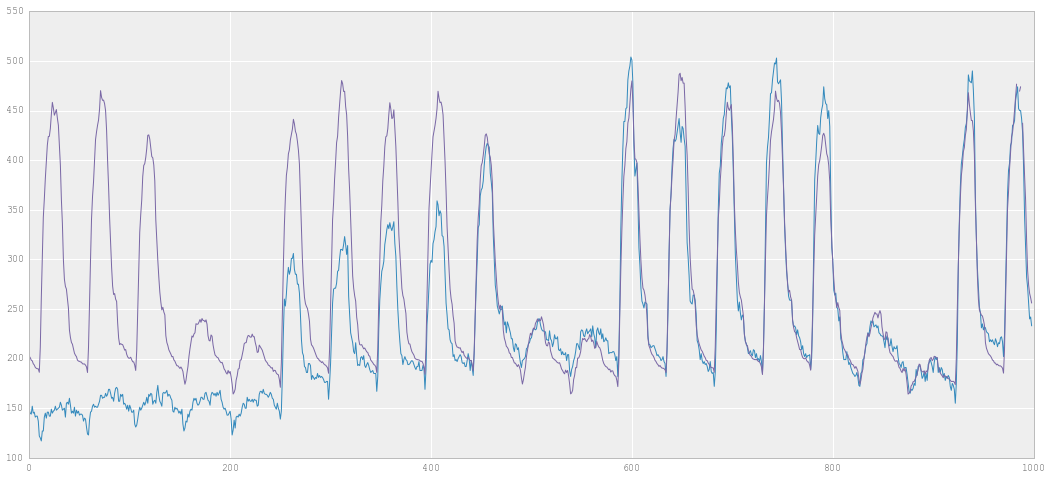

In [56]:
plt.plot(building2014.kW[1:1000])
plt.plot(building2014.prediction[1:1000])

To compensate for this, our model *under*estimates the rest of the year. So we would like to mark public holidays and December holidays, and treat them differently. Note that we don't have to mark weekends, because they are already treated differently in our time-of-week (`weektime`) classification. The 2014 holiday times applicable to the building are:

1-13 Jan.

12-31 Dec.

21 Mar.

18, 21, 28 Apr.

1, 7 May

16 Jun.

24 Sept.

**2015**:

1-12 Jan.

3 Apr.

6 Apr.

27 Apr.

1 May

16 Jun.

I'm going to mark them in the code, but it would be quite easy to just mark them with an extra column in the csv file, manually.

In [57]:
holidays20145 = pd.date_range(start='2014-01-01',end='2014-01-13').union_many([pd.date_range(start='2014-12-12',end='2014-12-31'), 
['2014-03-21'],['2014-04-18'],['2014-04-21'],['2014-04-28'],['2014-05-01'],['2014-05-01'],['2014-05-07'],
['2014-06-16'],['2014-09-24'], pd.date_range(start='2015-01-01',end='2015-01-05'),['2014-04-03'],['2014-04-06'],
['2014-04-27'], ['2014-05-01'], ['2014-06-16']])

#Create calendar for holidays:
from pandas.tseries.offsets import CustomBusinessDay
workdays_calendar=pd.date_range(start='2014-01-01',end='2015-09-21',freq=CustomBusinessDay(holidays=holidays20145))

There is probably a more elegant way to do this in `Python`, but here goes... This ugly piece of code assigns zeroes and ones based on whether it is a holiday (or weekend), or a normal working day.

In [58]:
import datetime as dt
workdayslist = pd.DataFrame(index=workdays_calendar).index.to_series().apply(lambda x: dt.datetime.strftime(x,'%m-%d-%Y')).tolist()
building2014['holiday']=0

for i in range(0,np.size(building2014.holiday)):
    if not(building2014.index[i].date().strftime('%m-%d-%Y') in workdayslist):
            building2014.ix[i,'holiday']=1

To see if it worked, let's do a scatterplot of holidays vs workdays:

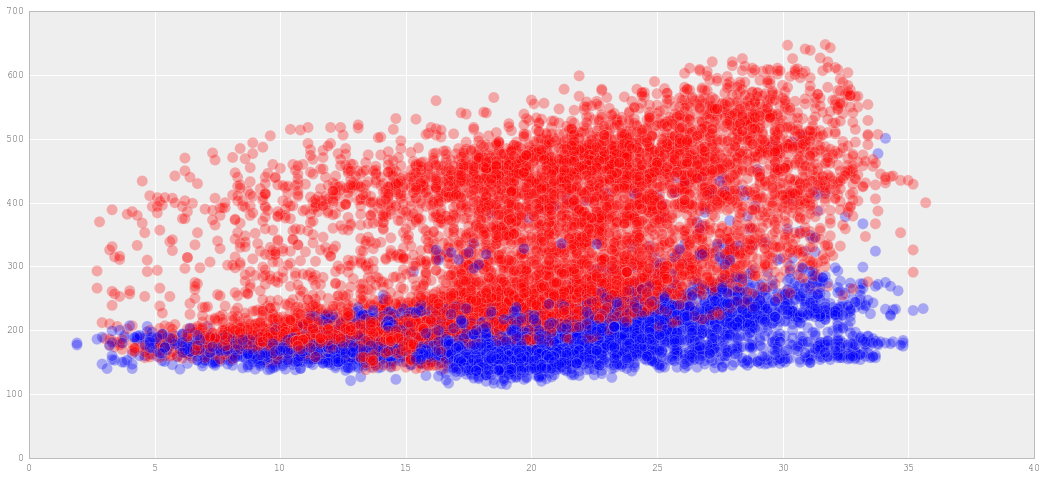

In [59]:
colors=np.where(building2014.holiday>0,'b','r')
plt.scatter(building2014.Temp,building2014.kW, s=120, c=colors,alpha=0.3)

It works quite well, but we still have quite a spread on the working day (red) data. 

### After hours energy use

It seems that we are still missing some factor: There seem to be two red data series. I suspect that it is because on some hot days, the HVAC system is still switched off after 16:30 and before 07:30 on work days, even though it is cold/hot outside. Let's see if we can catch it. I will use a very similar structure to the holidays one above. 

The long piece of code just creates a string for a datetime object in a format that `Pandas` understands. Here is one example:

In [60]:
pd.to_datetime([building2014.index[1].strftime('%Y')+'-'+building2014.index[1].strftime('%m')+'-'+building2014.index[1].strftime('%d')+ ' 16:30:00'])

DatetimeIndex(['2014-01-01 16:30:00'], dtype='datetime64[ns]', freq=None)

EES students, please note that you don't need to be able to do this.

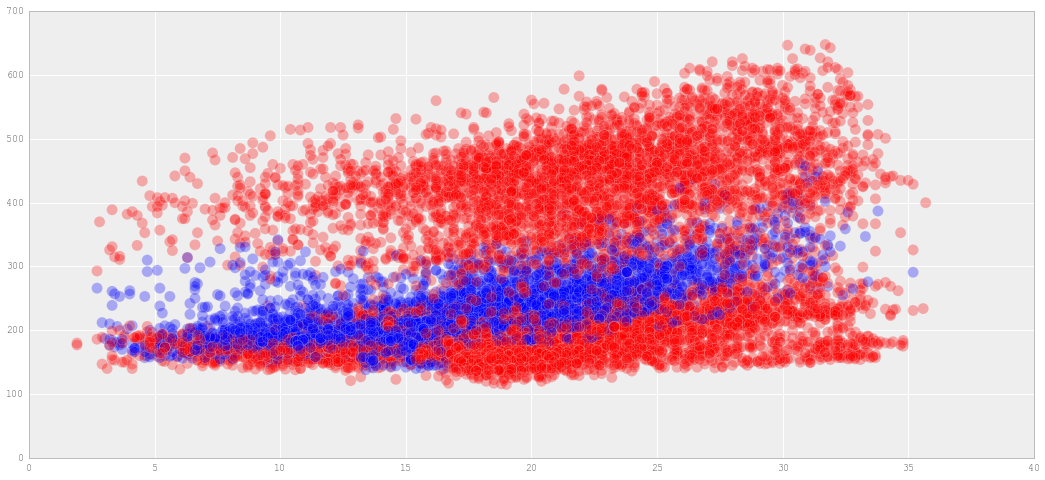

In [61]:
building2014['afterhours']=0
for i in range(0,np.size(building2014.afterhours)):
    if ((building2014.index[i]>pd.to_datetime([building2014.index[i].strftime('%Y')+'-'+building2014.index[i].strftime('%m')+'-'+building2014.index[i].strftime('%d')+ ' 16:30:00']) 
        or building2014.index[i]<pd.to_datetime([building2014.index[i].strftime('%Y')+'-'+building2014.index[i].strftime('%m')+'-'+building2014.index[i].strftime('%d')+ ' 07:30:00']))
        and building2014.ix[i,'holiday']==0):
            building2014.ix[i,'afterhours']=1
colors=np.where(building2014.afterhours>0,'b','r')
plt.scatter(building2014.Temp,building2014.kW, s=120, c=colors,alpha=0.3)

I think we have identified the missing factor. We can see three distinct lines: the bottom red one (holidays), the middle blue one (after hours on work days), and the top red one (during work hours on work days).

The widely scattered blue dots at the lower end of the temperature range are for the mornings.

But now, remember that we classify energy use per `weektime` category? So the after hours thing should be taken into account in our `weektime` variable anyway. No need to add another variable to the dataframe. It's just good that we know what is causing the phenomenon.

Now, to be honest, I don't see the piece-wise linear graph described in the paper. I think a straight line fit will be ok, and it is a lot less work, so I'm going to leave it at that for now.

### Regression using temperature, time-of-week, and holidays

We are ready to do the regression again, with the holidays added in, but ignoring the after-hours calculation above.

A brief note on the `patsy` formula for the regression equation. We need to take *interactions* into account. This means that temperature and time-of-week are not independent (so that we can just + them), but that a hot Wednesday afternoon will be different to a hot Sunday afternoon. Patsy handles these interactions with two operators. Suppose our two factors are $a$ and $b$:

: considers only $ab$

\* considers $a+b+ab$

The rest of the code below has been copied and pasted from cells above, and should not be new:

In [62]:
regression_equation='kW ~ weektime*Temp:holiday'
Energy,X_building = dmatrices(regression_equation, data=building2014, return_type='dataframe')
mod_building = sm.OLS(Energy,X_building)
res_building= mod_building.fit(L1_wt=0)
y_false_forecast,X_building2014 = dmatrices(regression_equation, data=building2014, return_type='dataframe')
energy_prediction=res_building.predict(X_building2014)

building2014['prediction']='' #create a blank column
k=0 #this is the counter for the forecast variable. It doesn't increment if there is no temperature data 
    #for that time point.
for i in range (0,np.size(building2014.Temp)):
    if pd.notnull(building2014.Temp[i]) and k<np.size(energy_prediction): #if there is a Temperature reading for that time period, then...
        building2014.ix[i,'prediction']=energy_prediction[k] #allocate the right forecast point to that time period
        k+=1 #increment forecast counter
    else:
        building2014.ix[i,'prediction']=np.NaN #Skip that time period, write NaN.

print("CVRMSE:\t" + "{:.3f}".format(CVRMSE(building2014.kW,building2014.prediction))+"\t NMBE:" +"{:.3f}".format(NMBE(building2014.kW,building2014.prediction)))

CVRMSE:	14.141	 NMBE:0.001


I can live with a CVRMSE of 14 and a NMBE of 0.001, given the crudeness of the model. 

### Forecast of 2015

It is now time to forecast the 2015 energy use, given our model with 2014 data. Let's start by importing the Temp2015.csv file:

In [63]:
Temp2015=pd.read_csv('Temp2015.csv',sep='\;',index_col=0,parse_dates=True,engine='python')
Temp2015

,Temp,WindChill,HeatIndex,THWIndex,THSWIndex
Date_Time,,,,,
2015-01-01 00:00:00,17.3,17.3,17.7,17.7,15.6
2015-01-01 00:30:00,17.1,17.1,17.4,17.4,15.3
2015-01-01 01:00:00,17.1,17.1,17.4,17.4,15.3
2015-01-01 01:30:00,17.3,17.3,17.8,17.8,15.7
2015-01-01 02:00:00,17.4,17.4,17.8,17.8,15.7
2015-01-01 02:30:00,17.4,17.4,17.7,17.7,15.6
2015-01-01 03:00:00,17.3,17.3,17.7,17.7,15.6
2015-01-01 03:30:00,17.2,17.2,17.6,17.6,15.4
...,...,...,...,...,...


Now, let's create the weektime indicator as above:

In [64]:
#Weektime procedure:
a=pd.Series(Temp2015.index.time).tolist()
b=pd.Series(Temp2015.index.weekday).tolist()
weektime_df=pd.DataFrame(data=pd.Series(["{}_{}".format(b,a) for a,b in zip(a, b)]),columns=["weektime"])
weektime_df.index=Temp2015.index
Temp2015['weektime']=weektime_df.weektime
Temp2015

,Temp,WindChill,HeatIndex,THWIndex,THSWIndex,weektime
Date_Time,,,,,,
2015-01-01 00:00:00,17.3,17.3,17.7,17.7,15.6,3_00:00:00
2015-01-01 00:30:00,17.1,17.1,17.4,17.4,15.3,3_00:30:00
2015-01-01 01:00:00,17.1,17.1,17.4,17.4,15.3,3_01:00:00
2015-01-01 01:30:00,17.3,17.3,17.8,17.8,15.7,3_01:30:00
2015-01-01 02:00:00,17.4,17.4,17.8,17.8,15.7,3_02:00:00
2015-01-01 02:30:00,17.4,17.4,17.7,17.7,15.6,3_02:30:00
2015-01-01 03:00:00,17.3,17.3,17.7,17.7,15.6,3_03:00:00
2015-01-01 03:30:00,17.2,17.2,17.6,17.6,15.4,3_03:30:00
...,...,...,...,...,...,...


Let's implement the 'holidays' procedure on the 2015 data. Remember that I defined the 2015 holidays above when I defined the 2014 holidays:

In [65]:
Temp2015['holiday']=0
for i in range(0,np.size(Temp2015.holiday)):
    if not(Temp2015.index[i].date().strftime('%m-%d-%Y') in workdayslist):
            Temp2015.ix[i,'holiday']=1

Since `patsy` needs a `kW` column to do it's thing, we'll create one and give at an arbitrary value of 5. It doesn't really matter, except that if you give it a value of 1, it may think that it is the intercept column.

In [66]:
Temp2015['kW']=5

We can now feed the Temp2015 DataFrame into `patsy` to give us a matrix that `statsmodels` will accept. There are probably better ways of doing this in `Python`.

In [67]:
y_false_forecast,X_building2015 = dmatrices(regression_equation, data=Temp2015, return_type='dataframe')
energy_forecast=res_building.predict(X_building2015)
energy_forecast

array([ 176.70572234,  174.85692139,  172.93417458, ...,  440.97462406,
        447.80006546,  456.00247337])

So there you have your answer: the 2015 energy use forecast, based on the temperature. However, if you're working in Python, you should remember that this array is shorter - you don't have blank spaces for the periods where you don't have data. So you need to spread it out again to the appropriate time periods, as was done with the 2014 prediction data above.

In [68]:
Temp2015['forecast']='' #create a blank column
k=0 #this is the counter for the forecast variable. It doesn't increment if there is no temperature data 
    #for that time point.
for i in range (0,np.size(Temp2015.Temp)):
    if pd.notnull(Temp2015.Temp[i]) and k<np.size(energy_forecast): #if there is a Temperature reading for that time period, then...
        Temp2015.ix[i,'forecast']=energy_forecast[k] #allocate the right forecast point to that time period
        k+=1 #increment forecast counter
    else:
        Temp2015.ix[i,'forecast']=np.NaN #Skip that time period, write NaN.

### Comparing our forecast to the actual data

Now that we have the forecast, we can compare it to the 2015 data to see how good it is. Note that in the test you won't have this luxury. The way it is usually done is to 'train' your model on half of your data (or some other percentage), and see how well it forecasts the second half. When you're satisfied, you 'train' it on the full data set to forecast 2015. Or you can use the 2014 and 2015 data sets in this example to test your code.
Let's import the 2015 energy values:

In [69]:
energy2015=pd.read_csv('energy2015.csv',sep='\;',index_col=0,parse_dates=True,engine='python')

I'll be using the same CVRMSE and NMBE functions defined above to evaluate the fit of them model:

In [70]:
print("CVRMSE:\t" + "{:.3f}".format(CVRMSE(energy2015.kW,Temp2015.forecast))+"\t NMBE:" +"{:.3f}".format(NMBE(energy2015.kW,Temp2015.forecast)))

CVRMSE:	19.903	 NMBE:-5.230


Of course, the CVRMSE will be higher than on the 2015 data, but I think that that is pretty cool, given the data at hand and the level of sophistication of the model.
In the [Lawrence Berkeley study](http://eetd.lbl.gov/publications/assessment-of-automated-measurement-a) above, commercial software packages were getting CVRMSE's of 7-16, and NMBE's of -3 to -0.5, on average.

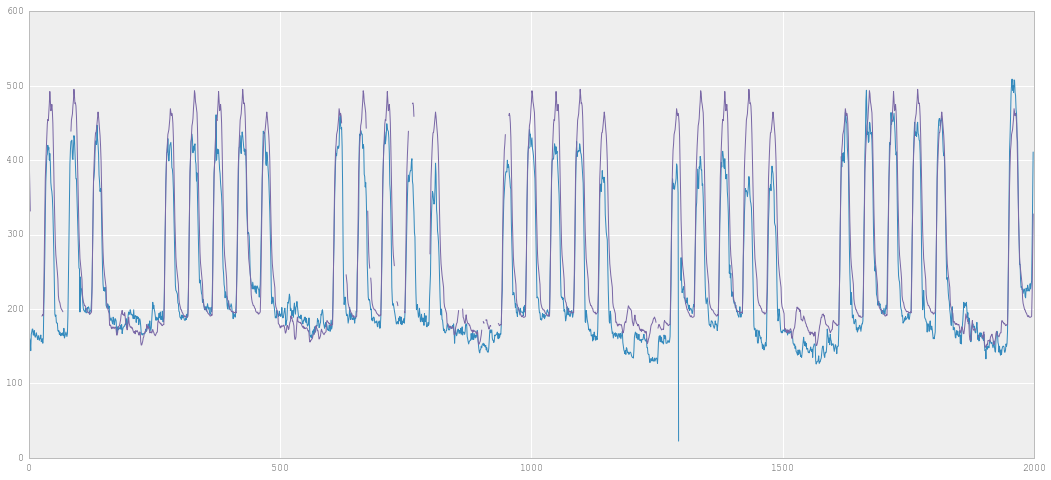

In [71]:
plt.plot(energy2015.kW[8000:10000])
plt.plot(Temp2015.forecast[8000:10000])

In [72]:
from sklearn.linear_model import LinearRegression
est=LinearRegression()
est.fit(X_building,Energy)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [73]:
forecast_sklearn=est.predict(X_building2015)
Temp2015['forecast_sklearn']='' #create a blank column
k=0 #this is the counter for the forecast variable. It doesn't increment if there is no temperature data 
    #for that time point.
for i in range (0,np.size(Temp2015.Temp)):
    if pd.notnull(Temp2015.Temp[i]): #and k<np.size(forecast_sklearn): #if there is a Temperature reading for that time period, then...
        Temp2015.ix[i,'forecast_sklearn']=forecast_sklearn[k][0] #allocate the right forecast point to that time period
        k+=1 #increment forecast counter
    else:
        Temp2015.ix[i,'forecast_sklearn']=np.NaN #Skip that time period, write NaN.
print("CVRMSE:\t" + "{:.3f}".format(CVRMSE(energy2015.kW,Temp2015['forecast_sklearn']))+"\t NMBE:" +"{:.3f}".format(NMBE(energy2015.kW,Temp2015['forecast_sklearn'])))

CVRMSE:	19.903	 NMBE:-5.230


In [74]:
from sklearn.linear_model import Ridge
est=Ridge(alpha=0.01)
est.fit(X_building,Energy)

Ridge(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, solver='auto', tol=0.001)

In [75]:
forecast_sklearn=est.predict(X_building2015)
Temp2015['forecast_sklearn']='' #create a blank column
k=0 #this is the counter for the forecast variable. It doesn't increment if there is no temperature data 
    #for that time point.
for i in range (0,np.size(Temp2015.Temp)):
    if pd.notnull(Temp2015.Temp[i]): #and k<np.size(forecast_sklearn): #if there is a Temperature reading for that time period, then...
        Temp2015.ix[i,'forecast_sklearn']=forecast_sklearn[k][0] #allocate the right forecast point to that time period
        k+=1 #increment forecast counter
    else:
        Temp2015.ix[i,'forecast_sklearn']=np.NaN #Skip that time period, write NaN.
print("CVRMSE:\t" + "{:.3f}".format(CVRMSE(energy2015.kW,Temp2015['forecast_sklearn']))+"\t NMBE:" +"{:.3f}".format(NMBE(energy2015.kW,Temp2015['forecast_sklearn'])))

CVRMSE:	19.904	 NMBE:-5.231
